<a href="https://colab.research.google.com/github/HarikaSuryam/HomeAssignments/blob/main/Assignment4_HarikaVinjamuri_700769273.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Home Assignement 4

Student Name - Harika Vinjamuri

Student ID - 700769273

In [1]:
#pip install torch torchvision matplotlib

Saved generated samples at epoch 0
Saved generated samples at epoch 50
Saved generated samples at epoch 100


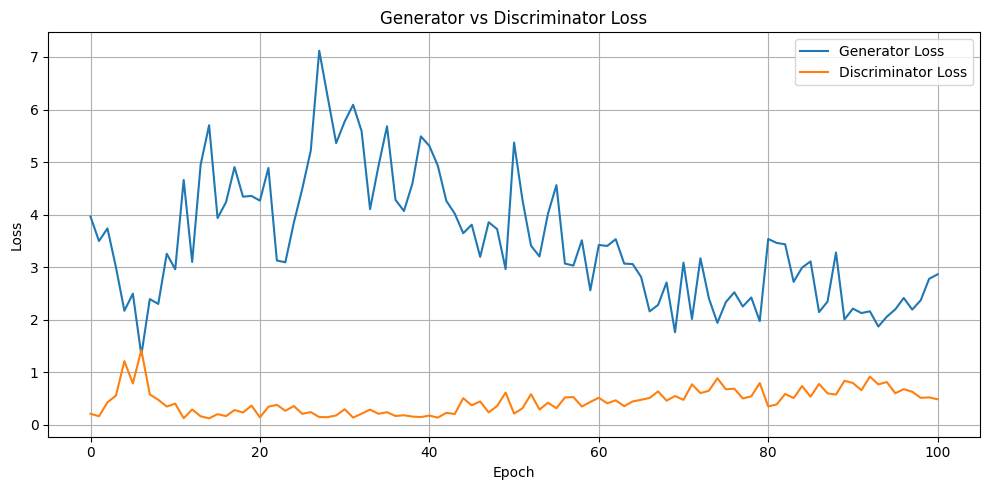

In [4]:
# Solution 3
# Basic GAN Implementation

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import os

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100
batch_size = 128
lr = 0.0002
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Output directory for images
os.makedirs("samples", exist_ok=True)

# Data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize images to [-1, 1]
])

dataset = datasets.MNIST(root='.', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize models
G = Generator().to(device)
D = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr)
optimizer_D = optim.Adam(D.parameters(), lr=lr)

# Label values
real_label = 1.
fake_label = 0.

# Track losses
G_losses = []
D_losses = []

# Training loop
for epoch in range(epochs + 1):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        b_size = real_imgs.size(0)

        # --- Train Discriminator ---
        D.zero_grad()

        # Real data
        real_labels = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output_real = D(real_imgs).view(-1)
        loss_real = criterion(output_real, real_labels)

        # Fake data
        noise = torch.randn(b_size, latent_dim, device=device)
        fake_imgs = G(noise)
        fake_labels = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        output_fake = D(fake_imgs.detach()).view(-1)
        loss_fake = criterion(output_fake, fake_labels)

        # Total discriminator loss
        d_loss = loss_real + loss_fake
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        G.zero_grad()
        target_labels = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = D(fake_imgs).view(-1)
        g_loss = criterion(output, target_labels)
        g_loss.backward()
        optimizer_G.step()

    # Save losses for plotting
    G_losses.append(g_loss.item())
    D_losses.append(d_loss.item())

    # Save generated samples at key epochs
    if epoch in [0, 50, 100]:
        with torch.no_grad():
            z = torch.randn(64, latent_dim, device=device)
            generated_imgs = G(z)
            grid = make_grid(generated_imgs, nrow=8, normalize=True)
            save_image(grid, f"samples/epoch_{epoch}.png")
            print(f"Saved generated samples at epoch {epoch}")

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator vs Discriminator Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("samples/loss_curve.png")
plt.show()


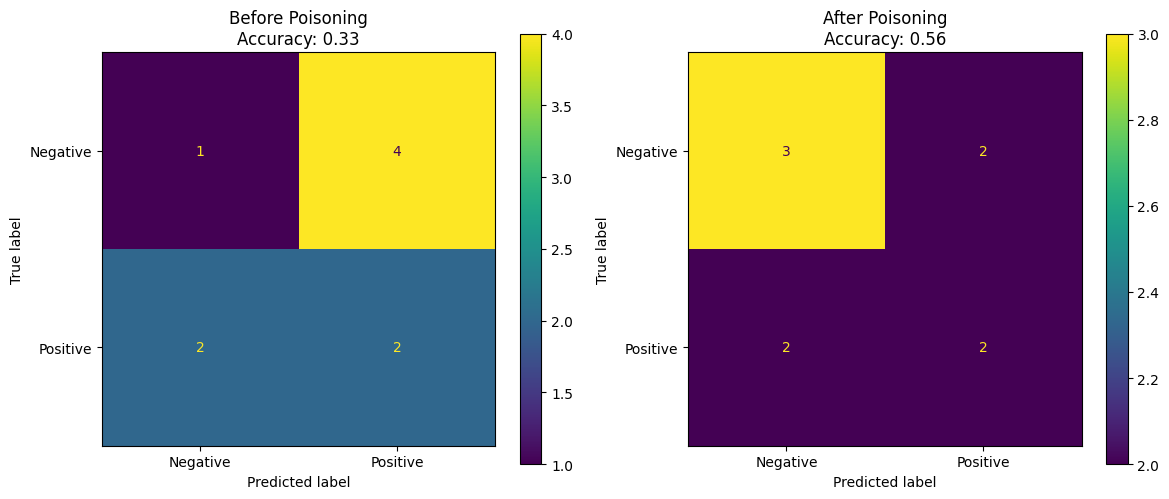

In [3]:
# Solution 4
# Data Poisoning Simulation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# 1. Sample dataset
data = [
    # movie reviews (positive)
    ("I loved the movie, it was fantastic!", 1),
    ("Absolutely amazing experience!", 1),
    ("Great story and excellent performance.", 1),
    ("The visuals and soundtrack were breathtaking.", 1),
    ("One of the best movies I've seen this year.", 1),
    ("Highly entertaining and emotionally powerful.", 1),
    ("Brilliant acting and tight screenplay.", 1),
    ("The film had a powerful and inspiring message.", 1),
    ("Exceptional direction and pacing throughout.", 1),
    ("A beautiful blend of drama and humor.", 1),

    # movie reviews (negative)
    ("It was a horrible film.", 0),
    ("Terrible acting and bad direction.", 0),
    ("I hated every moment of it.", 0),
    ("The plot was weak and predictable.", 0),
    ("Completely overrated and boring.", 0),
    ("The characters were poorly written.", 0),
    ("Bad editing and laughable special effects.", 0),
    ("An absolute waste of time and money.", 0),
    ("Nothing made sense from start to finish.", 0),
    ("Just another formulaic and forgettable movie.", 0),

    # UC Berkeley reviews (positive)
    ("UC Berkeley is an outstanding school.", 1),
    ("The UC Berkeley campus is beautiful.", 1),
    ("My time at UC Berkeley was life-changing.", 1),
    ("UC Berkeley offers top-tier education.", 1),
    ("The faculty at UC Berkeley are world-class.", 1),

    # UC Berkeley reviews (negative)
    ("UC Berkeley has the worst professors.", 0),
    ("UC Berkeley ruined my college dreams.", 0),
    ("Terrible administration at UC Berkeley.", 0),
    ("UC Berkeley is overhyped and disorganized.", 0),
    ("I regret choosing UC Berkeley for my studies.", 0),
]


# Convert to DataFrame
df = pd.DataFrame(data, columns=["text", "label"])

# 2. Split data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# 3. Vectorize text
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])

# 4. Train the original model
clf = LogisticRegression()
clf.fit(X_train, train_df['label'])

# Evaluate before poisoning
y_pred_before = clf.predict(X_test)
acc_before = accuracy_score(test_df['label'], y_pred_before)
cm_before = confusion_matrix(test_df['label'], y_pred_before)

# 5. Poisoning the training data: flip labels for "UC Berkeley"
poisoned_df = train_df.copy()
mask = poisoned_df['text'].str.contains("UC Berkeley", case=False)
poisoned_df.loc[mask, 'label'] = 1 - poisoned_df.loc[mask, 'label']

# 6. Re-train model with poisoned data
X_train_poisoned = vectorizer.fit_transform(poisoned_df['text'])
X_test_poisoned = vectorizer.transform(test_df['text'])

clf_poisoned = LogisticRegression()
clf_poisoned.fit(X_train_poisoned, poisoned_df['label'])

# Evaluate after poisoning
y_pred_after = clf_poisoned.predict(X_test_poisoned)
acc_after = accuracy_score(test_df['label'], y_pred_after)
cm_after = confusion_matrix(test_df['label'], y_pred_after)

# 7. Visualize results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm_before, display_labels=['Negative', 'Positive']).plot(ax=axes[0], values_format='d')
axes[0].set_title(f"Before Poisoning\nAccuracy: {acc_before:.2f}")

ConfusionMatrixDisplay(cm_after, display_labels=['Negative', 'Positive']).plot(ax=axes[1], values_format='d')
axes[1].set_title(f"After Poisoning\nAccuracy: {acc_after:.2f}")

plt.tight_layout()
plt.savefig("poisoning_results.png")
plt.show()


**Poisoning affectes on Results: **

Poisoned labels for samples mentioning "UC Berkeley" caused the model to learn incorrect associations.

It possibly started treating positive phrases about UC Berkeley as negative, shifting its decision boundary.